In [27]:
import pandas as pd
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math
from sklearn.preprocessing import RobustScaler
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:

from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

In [29]:

from keras.models import load_model
import keras

In [30]:
data = pd.read_csv("data_final.csv",index_col='Date',parse_dates=[0])
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
data.dropna(axis=0, inplace=True)
data.head()

,DJI,SnP500,NASDAQ,Russell_3000,Willshire_5000,ma7,ma21,26ema,12ema,MACD,...,lower_band,fourier_3,fourier_6,fourier_9,compound_mean,compound_max,compound_min,subjectivity_mean,subjectivity_max,ARIMA_preds
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-08,11510.74,1267.79,2269.76,739.708,12923.12,11461.20857,11514.36476,11478.25286,11446.58481,-31.668043,...,11197.46843,12487.83269,12530.99935,12644.36571,-0.397199,0.6343,-0.8750,0.243113,1.000000,11233.93503
2008-09-09,11230.73,1224.51,2209.81,713.683,12476.62,11392.00143,11490.38429,11455.78510,11412.51284,-43.272259,...,11162.89847,12461.50031,12475.70088,12564.50891,-0.249318,0.4767,-0.8356,0.279443,1.000000,11496.60343
2008-09-10,11268.92,1232.04,2228.70,719.149,12570.27,11352.76857,11465.93524,11439.10182,11389.93750,-49.164327,...,11124.43496,12435.20305,12420.40072,12484.64804,-0.393932,0.5859,-0.8316,0.277159,1.000000,11248.84115
2008-09-11,11433.71,1249.05,2258.22,727.788,12715.68,11340.88143,11455.99429,11438.62765,11396.79619,-41.831467,...,11114.48895,12408.94185,12365.10615,12404.80434,-0.216555,0.2023,-0.7845,0.183630,0.717857,11279.41108
2008-09-12,11421.99,1251.70,2261.27,730.425,12764.88,11325.04000,11450.71000,11437.18451,11400.73260,-36.451910,...,11113.17756,12382.71766,12309.82450,12324.99899,-0.198364,0.6124,-0.7992,0.231222,0.900000,11411.20178


In [31]:
data['Pct'] = data['DJI'].pct_change()

In [32]:
data.shape

(1969, 23)

In [33]:
data.iloc[:,1:]

,SnP500,NASDAQ,Russell_3000,Willshire_5000,ma7,ma21,26ema,12ema,MACD,20sd,...,fourier_3,fourier_6,fourier_9,compound_mean,compound_max,compound_min,subjectivity_mean,subjectivity_max,ARIMA_preds,Pct
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-08,1267.79,2269.760,739.708,12923.12,11461.20857,11514.36476,11478.25286,11446.58481,-31.668043,158.448167,...,12487.83269,12530.99935,12644.36571,-0.397199,0.6343,-0.8750,0.243113,1.000000,11233.93503,NaN
2008-09-09,1224.51,2209.810,713.683,12476.62,11392.00143,11490.38429,11455.78510,11412.51284,-43.272259,163.742908,...,12461.50031,12475.70088,12564.50891,-0.249318,0.4767,-0.8356,0.279443,1.000000,11496.60343,-0.024326
2008-09-10,1232.04,2228.700,719.149,12570.27,11352.76857,11465.93524,11439.10182,11389.93750,-49.164327,170.750137,...,12435.20305,12420.40072,12484.64804,-0.393932,0.5859,-0.8316,0.277159,1.000000,11248.84115,0.003400
2008-09-11,1249.05,2258.220,727.788,12715.68,11340.88143,11455.99429,11438.62765,11396.79619,-41.831467,170.752667,...,12408.94185,12365.10615,12404.80434,-0.216555,0.2023,-0.7845,0.183630,0.717857,11279.41108,0.014623
2008-09-12,1251.70,2261.270,730.425,12764.88,11325.04000,11450.71000,11437.18451,11400.73260,-36.451910,168.766222,...,12382.71766,12309.82450,12324.99899,-0.198364,0.6124,-0.7992,0.231222,0.900000,11411.20178,-0.001025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,2000.54,4594.443,1177.348,20675.10,17663.23571,17773.00571,17714.65829,17657.37282,-57.285468,231.089680,...,13154.77579,13892.03013,14578.28256,-0.178949,0.8442,-0.8720,0.359450,1.000000,17425.01533,-0.014971
2016-06-28,2036.09,4691.867,1198.448,21045.53,17625.31571,17750.93429,17692.07027,17619.27239,-72.797881,243.211659,...,13127.87502,13839.07350,14505.26278,-0.027012,0.8316,-0.8818,0.324485,1.000000,17181.32131,0.015722
2016-06-29,2070.77,4779.246,1219.612,21419.50,17609.57429,17746.52857,17692.26358,17630.87356,-61.390023,243.524620,...,13100.98547,13785.94182,14431.73272,-0.202743,0.7783,-0.9211,0.179425,0.906250,17392.48908,0.016368


In [63]:
seq_len = 21
shape = [seq_len, 23, 1]
neurons = [512, 512, 64, 1]
dropout = 0.2
epochs = 200

In [64]:
data.fillna(value=0,inplace=True)

                 DJI   SnP500   NASDAQ  Russell_3000  Willshire_5000  \
Date                                                                   
2008-09-08  11510.74  1267.79  2269.76       739.708        12923.12   
2008-09-09  11230.73  1224.51  2209.81       713.683        12476.62   
2008-09-10  11268.92  1232.04  2228.70       719.149        12570.27   
2008-09-11  11433.71  1249.05  2258.22       727.788        12715.68   
2008-09-12  11421.99  1251.70  2261.27       730.425        12764.88   

                    ma7         ma21        26ema        12ema       MACD  \
Date                                                                        
2008-09-08  11461.20857  11514.36476  11478.25286  11446.58481 -31.668043   
2008-09-09  11392.00143  11490.38429  11455.78510  11412.51284 -43.272259   
2008-09-10  11352.76857  11465.93524  11439.10182  11389.93750 -49.164327   
2008-09-11  11340.88143  11455.99429  11438.62765  11396.79619 -41.831467   
2008-09-12  11325.04000  11450.71

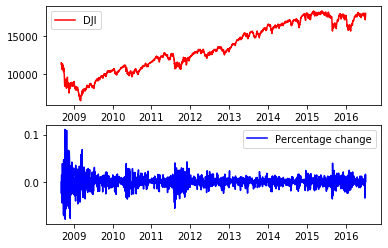

In [65]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['DJI'], color='red', label='DJI')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()
plot_stock(data)

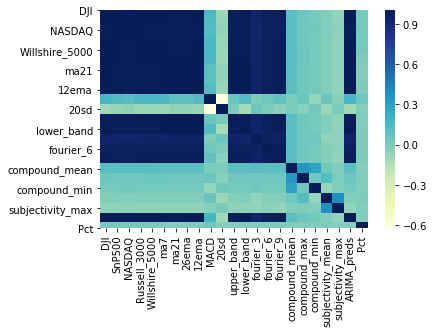

In [66]:
corr = data.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))

    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.8* result.shape[0]))
    print ("Amount of testing data = {}".format(0.2 * result.shape[0]))

    train = result[:int(row), :] # 90% date
    #print(train.shape)
    
    X_train = train[:, 1:] # all data until day m
    #print(X_train.shape)
    
    y_train = train[:, 0][:,0]# day m + 1 adjusted close price
    #print(y_train.shape)
    X_test = result[int(row):, 1:]
    y_test = result[int(row):, 0][:,0]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [69]:
X_train, y_train, X_test, y_test = load_data(data, seq_len)

Amount of features = 23
Amount of training data = 1557.6000000000001
Amount of testing data = 389.40000000000003


C:\Users\Taru Tak\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [70]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    model.add(LSTM(neurons[0],activation='relu', input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1],activation='relu', input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['mean_squared_error'])
    model.summary()
    return model

In [71]:
model = build_model(shape, neurons, dropout, decay=.4)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 512)           1097728   
_________________________________________________________________
dropout_6 (Dropout)          (None, 21, 512)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 3,229,825
Trainable params: 3,229,825
Non-trainable params: 0
____________________________________________

In [72]:
history=model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=epochs,verbose=1)

Train on 1558 samples
Epoch 1/200
1558/1558 [==============================] - 3s 2ms/sample - loss: 72268900.1078 - mean_squared_error: 72268912.0000
Epoch 2/200
1558/1558 [==============================] - 1s 347us/sample - loss: 39863387.4429 - mean_squared_error: 39863384.0000
Epoch 3/200
1558/1558 [==============================] - 1s 354us/sample - loss: 8238065.6470 - mean_squared_error: 8238065.5000
Epoch 4/200
1558/1558 [==============================] - 1s 351us/sample - loss: 6601209.8671 - mean_squared_error: 6601209.5000
Epoch 5/200
1558/1558 [==============================] - 1s 347us/sample - loss: 4534407.1970 - mean_squared_error: 4534406.5000
Epoch 6/200
1558/1558 [==============================] - 1s 345us/sample - loss: 2826280.5477 - mean_squared_error: 2826280.5000
Epoch 7/200
1558/1558 [==============================] - 1s 346us/sample - loss: 2518736.8578 - mean_squared_error: 2518736.7500
Epoch 8/200
1558/1558 [==============================] - 1s 350us/sample 

1558/1558 [==============================] - 1s 350us/sample - loss: 192054.2137 - mean_squared_error: 192054.2188
Epoch 127/200
1558/1558 [==============================] - 1s 358us/sample - loss: 193994.8313 - mean_squared_error: 193994.7969
Epoch 128/200
1558/1558 [==============================] - 1s 348us/sample - loss: 200309.0318 - mean_squared_error: 200309.0469
Epoch 129/200
1558/1558 [==============================] - 1s 351us/sample - loss: 213059.1001 - mean_squared_error: 213059.0938
Epoch 130/200
1558/1558 [==============================] - 1s 351us/sample - loss: 227305.3871 - mean_squared_error: 227305.3906
Epoch 131/200
1558/1558 [==============================] - 1s 353us/sample - loss: 262994.9462 - mean_squared_error: 262994.9375
Epoch 132/200
1558/1558 [==============================] - 1s 350us/sample - loss: 233261.9486 - mean_squared_error: 233261.9531
Epoch 133/200
1558/1558 [==============================] - 1s 348us/sample - loss: 183877.1281 - mean_squared_e

In [73]:

def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [74]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 5657989.10655 MSE (2378.65 RMSE)
Test Score: 10068973.46272 MSE (3173.16 RMSE)


(5657989.106546855, 10068973.462724935)

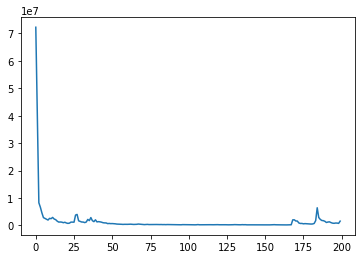

In [75]:
plt.plot(model.history.history["loss"])

In [76]:
p_train=model.predict(X_train)
p_test =model.predict(X_test)

In [77]:
def plot_result(stock_name, pred, test):
    plt.plot(pred, color='red', label='Prediction')
    plt.plot(test,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('The test result for {}'.format(stock_name))
    plt.xlabel('Days')
    plt.ylabel('Adjusted Close')
    plt.show()

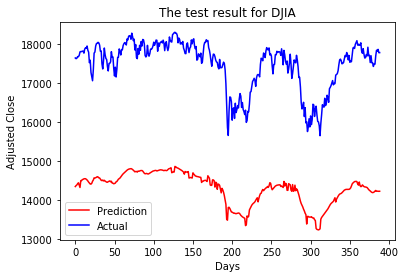

In [78]:

plot_result("DJIA", p_test, y_test)

In [79]:
def plot_result(stock_name, pred, train):
    plt.plot(pred, color='red', label='Prediction')
    plt.plot(train,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('The train result for {}'.format(stock_name))
    plt.xlabel('Days')
    plt.ylabel('Close')
    plt.show()

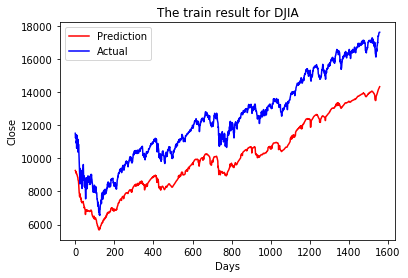

In [80]:

plot_result("DJIA", p_train, y_train)